# Prediction of phase-separation propensities of disordered proteins from sequence

This Colab notebook enables prediction of IDR transfer free energies and saturation concentrations from sequence.
- The models have been trained on CALVADOS 2 slab simulation data.
- Conditions are fixed to T=293 K and I=150 mM.

<b>How to cite this notebook:</b>
- S. von Bülow, G. Tesei, F. K. Zaidi, T. Mittag, K. Lindorff-Larsen, __Prediction of phase-separation propensities of disordered proteins from sequence__. _Proc. Natl. Acad. Sci. U.S.A._ (2025)

Further references:
- Use of $\nu_\mathrm{SVR}$: <br>
G. Tesei, A. I. Trolle, N. Jonsson, J. Betz, F. Pesce, K. E. Johansson, K. Lindorff-Larsen, __Conformational ensembles of the human intrinsically disordered proteome__. _Nature_ (2024) 626, 897–904. DOI: https://doi.org/10.1038/s41586-023-07004-5
- CALVADOS 2 model: <br>
G. Tesei and K. Lindorff-Larsen, __Improved predictions of phase behaviour of intrinsically disordered proteins by tuning the interaction range [version 2; peer review: 2 approved]__. _Open Research Europe_ (2023) 2(94). DOI: https://doi.org/10.12688/openreseurope.14967.2

Author: Sören von Bülow (soren.bulow@bio.ku.dk)

In [2]:
#@title <b>Preliminary operations</b>

import os
import warnings
warnings.simplefilter("ignore")

print('Setting up the environment...')

!rm -r sample_data &> dump
!rm sequence.* &> dump
!rm svr_model_nu* &> dump
!rm residues* &> dump
!rm example* &> dump
!rm predictor.* &> dump
!rm *joblib &> dump

github_folder = 'https://raw.githubusercontent.com/KULL-Centre/_2024_buelow_PSpred/main'

print(f'Downloading files from {github_folder}')

os.system(f'wget {github_folder}/scripts_colab/sequence.py')
os.system(f'wget {github_folder}/scripts_colab/predictor.py')
os.system(f'wget {github_folder}/data/residues.csv')
os.system(f'wget {github_folder}/data/example.fasta')
os.system(f'wget -O model_dG.joblib {github_folder}/models/idrome90/mlp/dG/model.joblib')
os.system(f'wget -O model_logcdil_mgml.joblib {github_folder}/models/idrome90/mlp/logcdil_mgml/model.joblib')
os.system(f'wget -O svr_model_nu.joblib {github_folder}/models/svr_model_nu.joblib')

!pip install 'scikit-learn==1.6' MDAnalysis biopython numba &> dump

import joblib
import sklearn
import pandas as pd

import sequence
from predictor import *

import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab import files

ncrossval = 50
print('Environment set up.')
print('Loading models...')

residues = pd.read_csv('residues.csv').set_index('one')
nu_file = 'svr_model_nu.joblib'

features = ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij','nu_svr']

features_clean = {
    'mean_lambda' : 'lambda',
    'faro' : 'f(aromatics)',
    'shd' : 'SHD',
    'ncpr' : 'NCPR',
    'fcr' : 'FCR',
    'scd' : 'SCD',
    'ah_ij' : 'LJ pairs',
    'nu_svr' : 'nu(SVR)'
}

print('Input features are:')
print('>>>>> '+ ', '.join([features_clean[fe] for fe in features]))

!touch calvados.py

models = {}
models['dG'] = joblib.load(f'model_dG.joblib')
models['logcdil_mgml'] = joblib.load(f'model_logcdil_mgml.joblib')

mltype = 'mlp'
alpha = 5
layers = (10,10)

targets = ['dG','logcdil_mgml']
targets_clean = {
    'dG' : 'Delta G',
    'logcdil_mgml' : 'Saturation concentration',
}

print('Models loaded.')

Setting up the environment...


Environment set up.
Loading models...
Input features are:
>>>>> lambda, f(aromatics), SHD, NCPR, FCR, SCD, LJ pairs, nu(SVR)
Models loaded.


In [3]:
#@title <b>Predict single IDR sequence</font></b>

try:
    os.rmdir('sample_data')
except:
    pass

NAME = "LAF1" #@param {type:"string"}
SEQUENCE = "LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES" #@param {type:"string"}
CHARGE_TERMINI = True # @param {type:'boolean'}
TEMPERATURE = "293 K (fixed)" # @param ['293 K (fixed)']
IONIC_STRENGTH = "150 mM (fixed)" # @param ['150 mM (fixed)']

seq = SEQUENCE
if " " in seq:
    seq = ''.join(seq.split())
    print('Blank character(s) found in the provided sequence. Sequence has been corrected, but check for integrity.')

print('='*80)
print(f'NAME: {NAME}')
print(f'SEQUENCE: {seq}')

seqfeats = sequence.SeqFeatures(seq,residues=residues,charge_termini=CHARGE_TERMINI)
X = X_from_seq(seq,features,residues=residues,charge_termini=CHARGE_TERMINI,nu_file=nu_file)

for target in targets:
  print('-'*80)
  ys = models[target].predict(X)#,models)
  ys_m = np.mean(ys)

  if target == 'dG':
    output = ys_m
    unit = 'kT'
    lower = ys_m - 1
    upper = ys_m + 1
  elif target == 'logcdil_mgml':
    output = np.exp(ys_m)
    lower = np.exp(ys_m-0.82)
    upper = np.exp(ys_m+0.82)
    unit = 'mg/mL'

  print(f'{targets_clean[target]:25s} = {output:5.1f} {unit:6s} ({lower:.1f} -- {upper:.1f} {unit})')
  if target == 'logcdil_mgml':
    output_uM = output / seqfeats.mw * 1e6
    lower_uM = lower / seqfeats.mw * 1e6
    upper_uM = upper / seqfeats.mw * 1e6
    print(f'{"":25s} = {output_uM:5.1f} {"uM":6s} ({lower_uM:.1f} -- {upper_uM:.1f} {"uM"})')
print('='*80)

NAME: LAF1
SEQUENCE: LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES
--------------------------------------------------------------------------------
Delta G                   =   0.1 kT     (-0.9 -- 1.1 kT)
--------------------------------------------------------------------------------
Saturation concentration  = 104.8 mg/mL  (46.2 -- 238.0 mg/mL)
                          = 23419.3 uM     (10314.6 -- 53173.4 uM)


In [ ]:
#@title <b>Run batch prediction</b>

#@markdown File name
FASTA_FILE = "peptides-fasta.fasta" #@param {type:"string"}
CHARGE_TERMINI = True # @param {type:'boolean'}
TEMPERATURE = "293 K (fixed)" # @param ['293 K (fixed)']
IONIC_STRENGTH = "150 uM (fixed)" # @param ['150 uM (fixed)']

if not os.path.isfile(FASTA_FILE):
  print(f'Please upload file {FASTA_FILE}')
  uploaded = files.upload()
  if FASTA_FILE not in uploaded.keys():
    raise NameError(f'Could not find file {FASTA_FILE}')

records = sequence.read_fasta(FASTA_FILE)

print('-'*80)
print(f'FASTA FILE: {FASTA_FILE}')
print(f'NUMBER OF SEQUENCES: {len(records)}')

#@title <b>Run batch prediction</font></b>

df_records = pd.DataFrame(dtype=object)

for name, record in tqdm(records.items(),total=len(records)):
  seq = str(record.seq)
  # check if the seq's each character is in the vocab
  vocab = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
  if not all(char in vocab for char in seq):
    print(seq)
    continue
  if len(seq) == 0:
    continue
  df_records.loc[name,'Sequence'] = seq
  seqfeats = sequence.SeqFeatures(seq,residues=residues,
                                  charge_termini=CHARGE_TERMINI,nu_file=nu_file)
  for feat in features:
    df_records.loc[name,feat] = getattr(seqfeats,feat)
  X = X_from_seq(seq,features,residues=residues,
                 charge_termini=CHARGE_TERMINI,nu_file=nu_file)
  for target in targets:
    ys = models[target].predict(X)#,models)
    ys_m = np.mean(ys)
    if target == 'dG':
      df_records.loc[name,'Delta G [kT]'] = ys_m
    if target == 'logcdil_mgml':
      cdil_mgml = np.exp(ys_m)
      df_records.loc[name,'Saturation concentration [mg/mL]'] = cdil_mgml
      cdil_uM = cdil_mgml / seqfeats.mw * 1e6
      df_records.loc[name,'Saturation concentration [uM]'] = cdil_uM

df_records.index.name = 'Name'
df_records.to_csv('df_PSprediction.csv')

print('\n')
print('='*114)
print(f'{"Name":20s} {"Sequence":33s} {"Delta G":>10s} {"Saturation":>16s} {"Saturation":>16s}')
print(f'{"":20s} {"":33s} {"":>10s} {"concentration":>16s} {"concentration":>16s}')
print(f'{"":20s} {"":33s} {"[kT]":>10s} {"[mg/mL]":>16s} {"[uM]":>16s}')

print('='*114)
for key, val in df_records.iterrows():
  if len(list(val["Sequence"])) > 30:
    seqpr = f'{val["Sequence"][:30]:30s}...'
  else:
    seqpr = f'{val["Sequence"][:30]:30s}'
  print(f'{key:20s} {seqpr:33s} {val["Delta G [kT]"]:10.1f} {val["Saturation concentration [mg/mL]"]:16.1f} {val["Saturation concentration [uM]"]:16.1f}')


--------------------------------------------------------------------------------
FASTA FILE: peptides-fasta.fasta
NUMBER OF SEQUENCES: 3212


 14%|█▍        | 445/3212 [01:28<12:14,  3.77it/s]

In [7]:
df_records.columns

Index(['Sequence', 'mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij',
       'nu_svr', 'Delta G [kT]', 'Saturation concentration [mg/mL]',
       'Saturation concentration [uM]'],
      dtype='object')

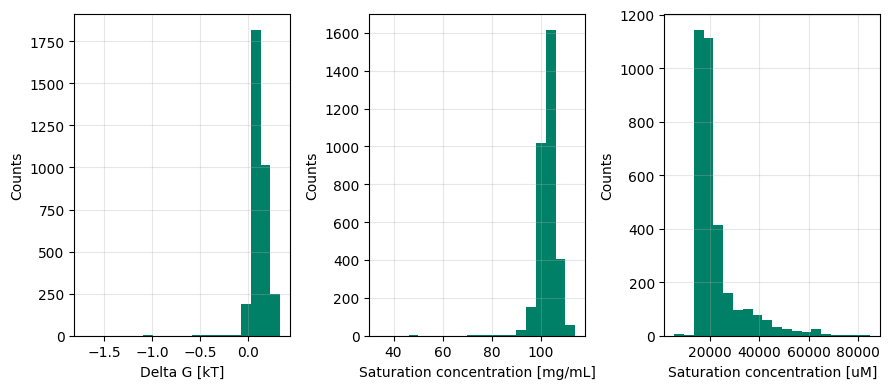

In [8]:
#@title <b>Analysis</font></b>

fcolor = plt.cm.summer

fig, ax = plt.subplots(1,3,figsize=(9,4))

for idx, target in enumerate(['Delta G [kT]','Saturation concentration [mg/mL]', 'Saturation concentration [uM]']):
  axij = ax[idx]
  axij.hist(df_records[target],bins=20,color=fcolor(0))

  axij.set_xlabel(f'{target}')
  axij.set_ylabel('Counts')
  axij.grid(alpha=0.3)
fig.tight_layout()

In [9]:
#@title <b>Download dataframe</font></b>

files.download('df_PSprediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>